In [1]:
from __future__ import absolute_import, division, print_function

import math
import os

import numpy as np

import scipy
import seaborn as sns

from time import time,sleep

import matplotlib.pyplot as plt
%matplotlib inline
import torch
print ("PyTorch version: " + torch.__version__)

sns.color_palette('Set2')


PyTorch version: 1.7.1


[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [2]:
# some helper functions
def compute_concord(t1,t2):
    '''Compute the concordance matrix'''
    n1 = np.size(t1)
    n2 = np.size(t2)
    
    t1 = np.reshape(t1,[n1,1])
    t2 = np.reshape(t2,[1,n2])
    # indicator function here
    C = np.array((t1-t2)>0,dtype=np.int)
    
    return C

def random_pairs(SX, ST, M):

    POS = list()
    NEG = list()
    POS_tt = list()
    NEG_tt = list()
    # random select M pairs in training to learn the conditional distribution of p(g(ii)>g(jj)|ii,jj)
    # with g(x) = x'beta+epsilon 
    for k in range(M):
        ii = 0
        jj = 0
        while ii==jj:
            # random find a pair each iteration
            ii = np.random.randint(n)
            jj = np.random.randint(n)
        # SFX: sorted FX
        # random selected pair from SFX
        xy = [SX[ii,0],SX[jj,0]]
        tt = [ST[ii,0], ST[jj,0]]
        # ST: sorted event time
        # with the same pair of index, if predicted x > predicted y
        # it's a positive pair
        if ST[ii,0]>ST[jj,0]:
            POS.append(xy)
            POS_tt.append(tt)
        else:
            #  otherwise when predicted x <= predicted y, it's a negative pare
            NEG.append(xy)
            NEG_tt.append(tt)
    POS = np.array(POS)
    NEG = np.array(NEG)

    X = np.concatenate((POS,NEG),axis=0)
    tt = np.concatenate((POS_tt,NEG_tt),axis=0)
    y = np.zeros([M,])


    nb_pos = np.shape(POS)[0]
    # label y as 1(POS),0(NEG)
    y[:nb_pos] = 1

    perm_idx = np.random.permutation(M)
    X = X[perm_idx,:]
    y = y[perm_idx]
    tt = tt[perm_idx]
    
    return(X,y,tt)

def sort_dataset(dataset):
    sidx = np.argsort(dataset['T'],axis=0)
    dataset['sorted_x'] = dataset['x'][sidx,:] # sorted predictor
    dataset['sorted_t'] = dataset['T'][sidx]   # sorted event time (wrt predictor)
    dataset['sorted_e'] = np.ones(len(sidx))   # sorted event time (wrt predictor)
    return (dataset)

def calculate_quantiles(post_prob, tt, percentiles):
    post_prob_sum = np.cumsum(post_prob)
    try:
        tt_p = [tt[np.argmin(np.abs(post_prob_sum-p))] for p in percentiles]
    except TypeError:
        tt_p = tt[np.argmin(np.abs(post_prob_sum-percentiles))]
        tt_p = [tt_p]
        
    return(np.array(tt_p))



In [3]:
def single_patient_true_dist_cox_gompertz(covariates, lambda_=7e-8, alpha_=0.2138, n=1000,seed=123,tt=np.linspace(0,1,100)):
    beta_linear = np.array([0.15,0.001])
    X_age = covariates[0]
    X_randon = covariates[1]
    X_cts = [X_age, X_randon]     
    X = X_cts
    
    U = np.random.uniform(size=n)
    # generate T accordingly
    T = (1/alpha_)*np.log(1-alpha_*np.log(U)/(lambda_*np.exp((np.dot(X,beta_linear)))))
    # generate labels (censoring or event)
    np.random.seed(seed)
    T_dist = 1-np.exp((lambda_/alpha_)*(1-np.exp(alpha_*tt)))
    
    return({"T": T, 'T_dist':T_dist})

def single_patient_true_dist_cox_gompertz_nonlinear(covariates, lambda_=7e-8, alpha_=0.2138, n=1000,seed=123):
    beta_linear = np.array([0.15,0.001])
    X_age = covariates[0]
    X_randon = covariates[1]
    X_cts = [X_age, X_randon]     
    X = np.array(X_cts)
    
    U = np.random.uniform(size=n)
    # generate T accordingly
    T = (1/alpha_)*np.log(1-alpha_*np.log(U)/(lambda_*np.exp((np.dot(X,beta_linear))**3)))
    # generate labels (censoring or event)
    np.random.seed(seed)
    
    return({"T": T})

In [5]:
from torch.utils.data import Dataset, DataLoader, Sampler
class SimpleDataset(Dataset):
    def __init__(self, x, y, e, transform=None):
        self.data = x
        self.targets = y
        self.label = e
        self.transform = transform

    def __getitem__(self, index):
        img = self.data[index]
        if self.transform is not None:
            img = self.transform(img)
        target = self.targets[index]
        label = self.label[index]
        return img, target, label

    def __len__(self):
        return len(self.data)


## Cox-gompertz linear setting

In [6]:
n = 10000
# first consider only 1 covariate
def simulation_cox_gompertz(n=10000, p=2, pc=0, pc_level=4, pval=[1/4.]*4, lambda_=7e-8, alpha_=0.2138, censor_bound= 68,seed=123):
    # linear relationship
    # n: number of patients
    # p: number of total covariates
    # pc: number of categorical variables
    # pc_level: levels of categorical variable
    # pval: probabilities for each level
    # lambda_exp: parameters for baseline hazards
    # censor_bound: upper bound of censoring generating process
    p_total = (p-pc) + pc*pc_level
    np.random.seed(seed)
    if p-pc == 2:
        # generate based on Bender's paper
#        beta_linear = np.array([0.15,0.001])
        beta_linear = np.array([0.15])
        X_age = np.random.normal(loc=24.3, scale = 8.38, size=n).reshape((n,1))
#        X_randon = np.random.normal(loc=266.84, scale = 507.82, size=n).reshape((n,1))
#        X_cts = np.concatenate((X_age, X_randon), axis=1)
        X_cts = X_age
    else:
        beta_linear = np.random.normal(0,1,p_total)
        X_cts = [np.random.normal(loc=0, scale=1.0, size=n) for i in range(p-pc)]
        X_cts = np.transpose(np.stack(X_cts, axis=0 ))

    if (pc>0):
        X_cat = [np.random.multinomial(1, pval, size=n) for i in range(pc)]
        X_cat = np.stack(X_cat, axis=0 ).reshape(n,pc_level*pc)
        one_hot_indices = [[i,i+1,i+2,i+3] for i in np.arange(p-pc,p_total, pc_level)]    
        X = np.concatenate((X_cts, X_cat), axis=1)
    else:
        X = X_cts
        one_hot_indices = []
        
    # the problem with the left tail is about this U!
    U = np.random.uniform(size=n)
    # generate T accordingly
    T = (1/alpha_)*np.log(1-alpha_*np.log(U)/(lambda_*np.exp(np.dot(X,beta_linear))))
    sidx = np.argsort(T,axis=0)
    TS = T[sidx]
    XS = X[sidx,:]
    np.random.seed(seed)
    # change the way censoring is defined
    # first set the maximum censoring at: censor_bound
#    C = np.repeat(censor_bound,n)
    right_truncate = T<censor_bound
    EPS = 0
    # define C only for the right truncated samples
    C = np.random.uniform(0+EPS,censor_bound,size=len(T[right_truncate]))
    CS = np.concatenate([C,np.repeat(censor_bound,n-len(T[right_truncate]))])
    event = 1*(TS<CS)
    nonevent = CS<TS
    # observed time
    YS = TS.copy()
    YS[nonevent] = CS[nonevent]
    
    # shuffle back to unsorted order
    perm_idx = np.random.permutation(n)
    X = XS[perm_idx,:]
    Y = YS[perm_idx]
    event = event[perm_idx]
    C = CS[perm_idx]
    T = TS[perm_idx]
    
    t = C*(C<T) +  T*(C>=T)
    return({"t": Y, "e":event, "x":X, "T": T,"C":C,'one_hot_indices':one_hot_indices})

# np.random.rand:  
# Create an array of the given shape and populate it with random samples from a uniform distribution over [0, 1).
# now X is uniform between [-3,3]
train = simulation_cox_gompertz(n=10000, seed=123)
test = simulation_cox_gompertz(n=5000, seed=124)

In [143]:
sidx

array([1515, 3405, 5026, ..., 2986, 3529, 2682])

(2606, 1)


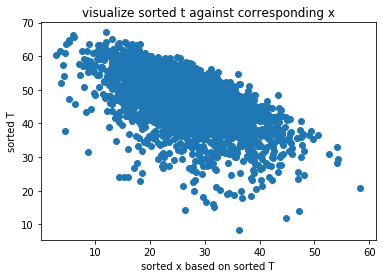

In [231]:
n=10000
X = train['x']
# beta_linear = np.array([0.15,0.001])
# FX = np.dot(X,beta_linear).reshape((n,1))
T = train['T']
# argsort gives the order of index based on the sorted value
e_idx = np.where(train['e']==1)[0]

n = len(sidx)

X_ = X[e_idx,:]
T_ = T[e_idx]
sidx = np.argsort(T_)

SX = X_[sidx,:] # sorted predictor
ST = T_[sidx]   # sorted event time (wrt predictor)
plt.plot(SX,ST,'o')
plt.xlabel("sorted x based on sorted T")
plt.ylabel("sorted T")
plt.title('visualize sorted t against corresponding x')
print(SX.shape)

## select pairs with data loader

In [27]:
train['t']

array([47.08421603, 13.0437119 ,  0.65090327, ..., 36.38521642,
       54.83780228, 36.78626283])

In [82]:
n=10000
X = train['x']
# beta_linear = np.array([0.15,0.001])
# FX = np.dot(X,beta_linear).reshape((n,1))
t = train['t']

trainData = SimpleDataset(X, t, train['e'])
pair1 = DataLoader(trainData, batch_size=1000,shuffle=True)
pair2 = DataLoader(trainData, batch_size=1000,shuffle=True)

In [83]:
validData = SimpleDataset(test['x'], test['t'], test['e'])
v_pair1 = DataLoader(validData, batch_size=5000,shuffle=True)
v_pair2 = DataLoader(validData, batch_size=5000,shuffle=True)

In [287]:
trainData = SimpleDataset(np.arange(10), np.arange(10), np.arange(10))
testloader = DataLoader(trainData, batch_size=1,shuffle=True)
testloader2 = DataLoader(trainData, batch_size=1,shuffle=True)

for j in range(5):
    print('epoch '+str(j))
    for i, ((x1, y1, e1), (x2, y2, e2))in enumerate(zip(testloader, testloader2)):
        print(x1, x2)


epoch 0
tensor([1]) tensor([5])
tensor([6]) tensor([6])
tensor([9]) tensor([4])
tensor([4]) tensor([3])
tensor([8]) tensor([7])
tensor([2]) tensor([1])
tensor([5]) tensor([0])
tensor([0]) tensor([2])
tensor([3]) tensor([8])
tensor([7]) tensor([9])
epoch 1
tensor([1]) tensor([8])
tensor([2]) tensor([3])
tensor([7]) tensor([9])
tensor([5]) tensor([5])
tensor([0]) tensor([0])
tensor([4]) tensor([7])
tensor([3]) tensor([2])
tensor([8]) tensor([6])
tensor([9]) tensor([4])
tensor([6]) tensor([1])
epoch 2
tensor([3]) tensor([5])
tensor([5]) tensor([0])
tensor([0]) tensor([2])
tensor([7]) tensor([6])
tensor([8]) tensor([8])
tensor([2]) tensor([7])
tensor([9]) tensor([3])
tensor([4]) tensor([1])
tensor([6]) tensor([4])
tensor([1]) tensor([9])
epoch 3
tensor([0]) tensor([5])
tensor([4]) tensor([6])
tensor([5]) tensor([4])
tensor([6]) tensor([0])
tensor([2]) tensor([3])
tensor([8]) tensor([8])
tensor([9]) tensor([1])
tensor([7]) tensor([7])
tensor([1]) tensor([2])
tensor([3]) tensor([9])
epoch 4


In [232]:
for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(v_pair1, v_pair2)):
    # PAIR 1 need to be non-censored ? +(1-e1)
    # y1 should not equal to y2
    delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
#     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
    x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
    x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]
    
    batch_label = 1*(y1 > y2)
    batch_pair = torch.cat([x1, x2],axis = 1)
    break

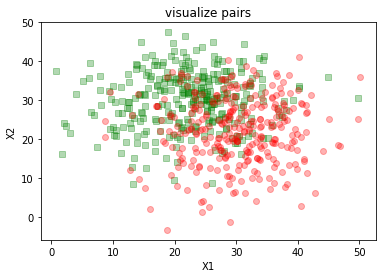

In [237]:
pos_idx = np.where(batch_label>0)
neg_idx = np.where(batch_label<1)
_ = plt.title('visualize pairs')
_ = plt.plot(batch_pair[pos_idx,0].tolist(),batch_pair[pos_idx,1].tolist(),'sg',alpha=.3, label='T(X1)>T(X2)')
_ = plt.plot(batch_pair[neg_idx,0].tolist(),batch_pair[neg_idx,1].tolist(),'or',alpha=.3, label='T(X1)<T(X2)')

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')

## define MLP classifier 

In [238]:
import torch
from torch import nn, optim
import numpy as np

# Type hinting
from typing import Union, List, Optional, Any, Tuple
from torch import FloatTensor, LongTensor

class SimpleMLP(nn.Module):
    def __init__(self, input_size=2, output_size=2, h_dim=[32,32]):
        super(SimpleMLP, self).__init__()
        net = []
        hs = [input_size] + h_dim + [output_size]
        for h0, h1 in zip(hs, hs[1:]):
            net.extend([
                nn.Linear(h0, h1),
                nn.ReLU(),
            ])
        net.pop()  # pop the last ReLU for the output layer
        self.net = nn.Sequential(*net)
        self.out = torch.nn.Sigmoid()
        
    def forward(self, x):
        z = self.net(x)
        return self.out(z)

In [239]:
hidden_layer=[32,32,1]
ncov = X.shape[1]
epochs = 1000
device = 'cpu'
# input is pair of X
clf = SimpleMLP(input_size = 2*ncov, output_size = 1, h_dim=hidden_layer)
print(clf)

# define optimizer
opt_clf = optim.Adam(clf.parameters(), lr=1e-4)

clf_path = '/Users/ZidiXiu/Dropbox/Research/ContrastiveSurvival/results/'+'clf.pt'

SimpleMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1, out_features=1, bias=True)
  )
  (out): Sigmoid()
)


In [240]:
best_valid_loss = np.inf
best_epoch = 0

train_loss_hist = []
valid_loss_hist = []
for epoch in range(1, epochs + 1):


    train_loss = 0
    valid_loss = 0

    print('epoch'+str(epoch))
    improved_str = " "
    clf.train()
    encoder.eval()
    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(pair1, pair2)):

        delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
    #     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
        x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
        x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]

        batch_label = (1*(y1 > y2)).to(device).squeeze().float()
        batch_pair = torch.cat([x1, x2],axis = 1).to(device).float()

        

        pred_label = clf(batch_pair)
        BCEloss = torch.nn.BCELoss()
        loss = BCEloss(pred_label.squeeze(), batch_label.float())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 1e-3)
        train_loss += loss.item()
        opt_clf.step()    

    train_loss = train_loss/(i+1)
    
    clf.eval()
    valid_loss = 0
    for i, ((x1, y1, e1), (x2, y2, e2)) in enumerate(zip(v_pair1, v_pair2)):
        delete_idx = (y1==y2)+(1-e1)*(1-e2) + (1-e1)*e2*(y1 <= y2)+ e1*(1-e2)*(y1 >= y2)
        
    #     keep_idx = e1*e2*(y1 > y2) + e1*e2*(y1 < y2)+ (1-e1)*e2*(y1 > y2) + e1*(1-e2)*(y1 < y2)
        x1, y1, e1 = x1[delete_idx==0,:], y1[delete_idx==0], e1[delete_idx==0]
        x2, y2, e2 = x2[delete_idx==0,:], y2[delete_idx==0], e2[delete_idx==0]

        batch_label = (1*(y1 > y2)).to(device).squeeze().float()
        batch_pair = torch.cat([x1, x2],axis = 1).to(device).float()

        pred_label = clf(batch_pair)
        BCEloss = torch.nn.BCELoss()
        valid_loss_ = BCEloss(pred_label.squeeze(), batch_label.float())

        valid_loss += valid_loss_



    valid_loss = valid_loss/(i+1)
    
    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)
    
    save_model = 0
    if (best_valid_loss > valid_loss_):
        save_model += 1

    if save_model >=1:
        best_epoch = epoch
        best_valid_loss = valid_loss_
        torch.save(clf.state_dict(), clf_path)

        improved_str = "*"
    print('====> Valid Pair number: {} \tCE loss: {:.4f} \tImproved: {}'.format(len(e1), valid_loss_.item(), improved_str))

    if epoch - best_epoch >=50:
        print('Model stopped due to early stopping')
        break

epoch1
====> Valid Pair number: 649 	CE loss: 0.8527 	Improved: *
epoch2
====> Valid Pair number: 641 	CE loss: 0.7976 	Improved: *
epoch3
====> Valid Pair number: 653 	CE loss: 0.7649 	Improved: *
epoch4
====> Valid Pair number: 657 	CE loss: 0.6971 	Improved: *
epoch5
====> Valid Pair number: 630 	CE loss: 0.6617 	Improved: *
epoch6
====> Valid Pair number: 632 	CE loss: 0.6347 	Improved: *
epoch7
====> Valid Pair number: 648 	CE loss: 0.6240 	Improved: *
epoch8
====> Valid Pair number: 643 	CE loss: 0.6128 	Improved: *
epoch9
====> Valid Pair number: 658 	CE loss: 0.6176 	Improved:  
epoch10
====> Valid Pair number: 638 	CE loss: 0.5913 	Improved: *
epoch11
====> Valid Pair number: 656 	CE loss: 0.5862 	Improved: *
epoch12
====> Valid Pair number: 621 	CE loss: 0.5889 	Improved:  
epoch13
====> Valid Pair number: 667 	CE loss: 0.5741 	Improved: *
epoch14
====> Valid Pair number: 605 	CE loss: 0.5729 	Improved: *
epoch15
====> Valid Pair number: 643 	CE loss: 0.5616 	Improved: *
epoc

====> Valid Pair number: 664 	CE loss: 0.4939 	Improved:  
epoch124
====> Valid Pair number: 674 	CE loss: 0.4727 	Improved:  
epoch125
====> Valid Pair number: 637 	CE loss: 0.5000 	Improved:  
epoch126
====> Valid Pair number: 648 	CE loss: 0.5156 	Improved:  
epoch127
====> Valid Pair number: 648 	CE loss: 0.4763 	Improved:  
epoch128
====> Valid Pair number: 664 	CE loss: 0.4897 	Improved:  
epoch129
====> Valid Pair number: 626 	CE loss: 0.4832 	Improved:  
epoch130
====> Valid Pair number: 617 	CE loss: 0.4953 	Improved:  
epoch131
====> Valid Pair number: 668 	CE loss: 0.4815 	Improved:  
epoch132
====> Valid Pair number: 661 	CE loss: 0.4700 	Improved:  
epoch133
====> Valid Pair number: 653 	CE loss: 0.5065 	Improved:  
epoch134
====> Valid Pair number: 682 	CE loss: 0.4861 	Improved:  
epoch135
====> Valid Pair number: 640 	CE loss: 0.4857 	Improved:  
epoch136
====> Valid Pair number: 647 	CE loss: 0.4832 	Improved:  
epoch137
====> Valid Pair number: 618 	CE loss: 0.5129 	I

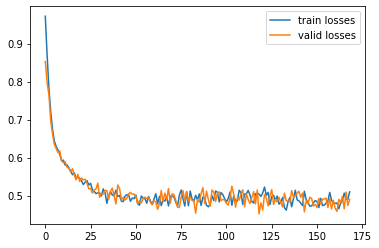

In [241]:
plt.plot(train_loss_hist,label="train losses")
plt.plot(valid_loss_hist,label="valid losses")
plt.legend()

In [242]:
import pandas as pd


plot_df = pd.DataFrame({'true': batch_label.detach().numpy(), 'pred': pred_label.squeeze().detach().numpy(),\
                        'dataPair1':batch_pair[:,0].detach().numpy(), 'dataPair2':batch_pair[:,1].detach().numpy()})
plot_df.head()

,true,pred,dataPair1,dataPair2
0,1.0,0.744528,25.781141,43.624172
1,1.0,0.744528,15.027925,21.310776
2,1.0,0.744528,20.414146,30.561441
3,1.0,0.744528,22.647816,30.683744
4,0.0,0.742164,15.022316,19.621126


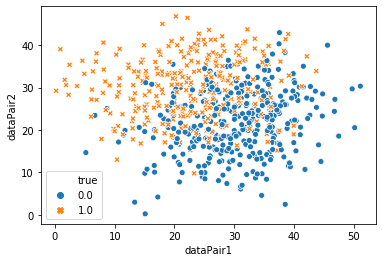

In [243]:
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="true", style="true")


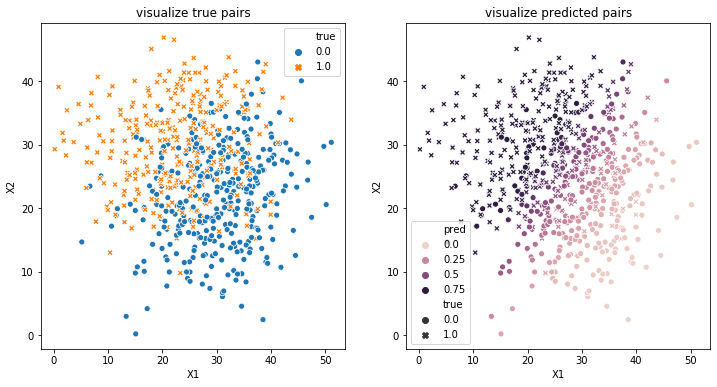

In [244]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
pos_idx = np.where(batch_label>0)
neg_idx = np.where(batch_label<1)

_ = plt.title('visualize true pairs')
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="true", style="true")

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')
plt.subplot(1, 2, 2)



_ = plt.title('visualize predicted pairs')
sns.scatterplot(data=plot_df, x="dataPair1", y="dataPair2", hue="pred", style="true")

# _ = plt.legend()
_ = plt.xlabel(u'X1')
_ = plt.ylabel(u'X2')

In [257]:
subj = np.random.sample(np.where(test['e']==1))
subj

TypeError: only integer scalar arrays can be converted to a scalar index

In [258]:
np.where(test['e']==1)

(array([  14,   16,   19, ..., 4992, 4996, 4998]),)

In [288]:
np.where(test['e']==1)
subj = 14

In [1]:
# Restore variables from disk.
clf.load_state_dict(torch.load(clf_path))
print("Model restored.")

# new object to predict g(x_subj)
# on the left
# subj = 2
# on the right
# subj=6
# relatively good 
# subj=8
x_subj = test['x'][subj]     # You can play with this
# x_subj = train['x'][subj]
draw_dataset = test
# Return evenly spaced numbers over a specified interval.
# is tt the we want?
# change tt to percentage scale

tt = np.percentile(train['T'],np.delete(np.linspace(0.,100.,1000, endpoint=False),0))
tt_bin = np.ones(len(tt))
# tt = np.linspace(ST[0]-0.5,ST[-1]+0.5,1000).reshape(1000)
# tt_bin = [y-x for x, y in zip(tt[:-1], tt[1:])]
# tt = np.delete(tt,0)

# SFX sorted original training dataset
x_subj_query = np.concatenate((np.tile(x_subj,[SX.shape[0],1]),SX),axis=1)

prob_subj = clf(torch.tensor(x_subj_query).to(device).float()).squeeze().detach().numpy()

# ST: sorted g(X_train)
# returns a matrix of size(tt)*size(ST)
# each ST corresponding to SFX
TC = compute_concord(tt,ST)

EPS = 1e-10
#aggregate information over bins
# binomial log-likelihood
tau = 0.2
score = np.mean(np.log(prob_subj+EPS)*TC+np.log(1-prob_subj+EPS)*(1-TC),axis=1)
score = score/tau
# normalize based on bin size!
post_prob = (np.exp(score)*tt_bin)/np.sum(np.exp(score)*tt_bin)

# np.save(output_dir+'/'+'M'+str(M0)+'replicate'+str(replicate_number)+"_MLP_post_prob",post_prob)




NameError: name 'clf' is not defined

In [2]:
width = 18
height = 6
plt.figure(figsize=(width, height))
plt.subplot(1,2,1)

plt.plot(SX, prob_subj, 'o')
plt.xlabel("sorted training X")
plt.ylabel("classifier output")
plt.axvline(draw_dataset['x'][subj],linestyle='--', label='x_k')
plt.legend()

plt.title("P(t_k>t_i|V_k, V_i)\n k is unknown, i is each training sample")


# plt.subplot(1,3,2)
# plt.plot(ST, prob_subj, 'o')
# plt.xlabel("training T based on sorted X")
# plt.ylabel("classifier output")
# plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')
# plt.legend()
# plt.title("P(t_k>t_i|V_k, V_i)\n k is unknown, i is each training sample")
# # plt.xlim(50,80)

plt.subplot(1,2,2)
true_T = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]))['T']
true_T_dist = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]), tt=tt)['T_dist']

plt.plot(tt, post_prob/0.1, label="Predicted")
plt.axvline(calculate_quantiles(post_prob, tt, 0.5),linestyle='--',color='blue',label='predicted median')

plt.ylabel('Prob(t(x)=t)')
plt.xlabel('Event time')
sns.distplot(true_T, rug=True, hist=False,label="Empirical")
plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')


#
ST_range = np.percentile(ST,[5,95])
plt.axvline(ST_range[0],linestyle='--',color='gray', label='Training data T range')
plt.axvline(ST_range[1],linestyle='--',color='gray')


plt.legend()
plt.title("Time-to-event distribution, event label:{}".format(test['e'][subj]))

NameError: name 'plt' is not defined

Text(0.5, 1.0, 'Time-to-event distribution')

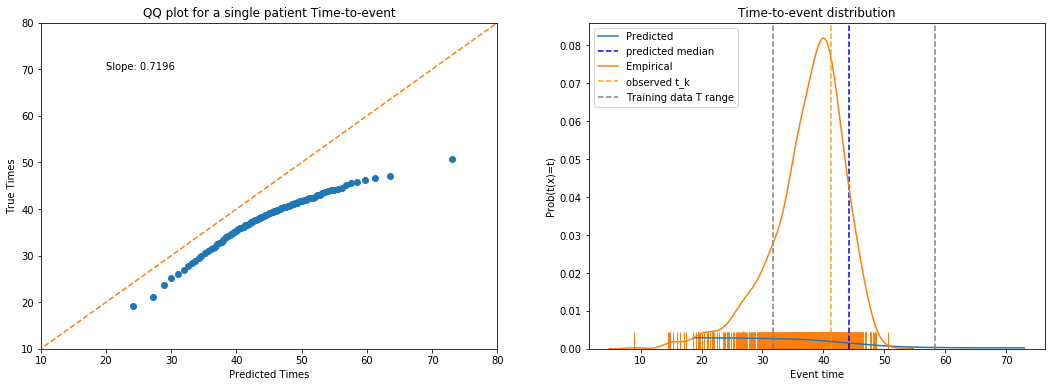

In [282]:
# calculate QQ-plot
import numpy as np
import matplotlib.pyplot as plt


pred_quantiles = calculate_quantiles(post_prob, tt, percentiles=np.linspace(0,1,100))
true_quantiles = np.percentile(true_T,np.linspace(0,100,100))
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(pred_quantiles, true_quantiles)

width = 18
height = 6
plt.figure(figsize=(width, height))

plt.subplot(1,2,1)
plt.text(20,70, 'Slope: '+str(np.round(slope,4)))
plt.plot(pred_quantiles, true_quantiles, 'o')
plt.plot(np.linspace(0,100,100),np.linspace(0,100,100), linestyle='--')
plt.xlim(10,80)
plt.ylim(10,80)
plt.xlabel('Predicted Times')
plt.ylabel('True Times')
plt.title('QQ plot for a single patient Time-to-event')

plt.subplot(1,2,2)
plt.plot(tt, post_prob, label="Predicted")
plt.axvline(calculate_quantiles(post_prob, tt, 0.5),linestyle='--',color='blue',label='predicted median')

plt.ylabel('Prob(t(x)=t)')
plt.xlabel('Event time')
sns.distplot(true_T, rug=True, hist=False, label="Empirical")

plt.axvline(draw_dataset['T'][subj],linestyle='--',color='orange',label='observed t_k')
true_T = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]))['T']
true_T_dist = single_patient_true_dist_cox_gompertz(np.concatenate([draw_dataset['x'][subj],[0]]), tt=tt)['T_dist']
ST_range = np.percentile(ST,[5,95])
plt.axvline(ST_range[0],linestyle='--',color='gray', label='Training data T range')
plt.axvline(ST_range[1],linestyle='--',color='gray')

plt.legend()
plt.title("Time-to-event distribution")

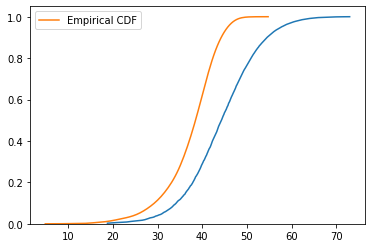

In [283]:
plt.plot(tt,np.cumsum(post_prob))
sns.distplot(true_T, hist=False, label="Empirical CDF", kde_kws=dict(cumulative=True))
